In [7]:
#import Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

In [8]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [236]:
# Read data
df=pd.read_csv('C:\\TensorFlow\\AAPL.csv')
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (755, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-09-06,107.9000,108.3000,107.5100,107.7000,102.6637,26880400
1,2016-09-07,107.8300,108.7600,107.0700,108.3600,103.2928,42364300
2,2016-09-08,107.2500,107.2700,105.2400,105.5200,100.5856,53002000
3,2016-09-09,104.6400,105.7200,103.1300,103.1300,98.3074,46557000
4,2016-09-12,102.6500,105.7200,102.5300,105.4400,100.5094,45292800


In [240]:
#check data types of columns
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [239]:
df["Open"] = pd.to_numeric(df["Open"],errors="coerce")

In [241]:
#no missing value
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [14]:
# Convert Date to datetime
df["Date"] = pd.to_datetime(df["Date"])

In [242]:
# create different aggregation levels
df["Year"] = df["Date"].apply(lambda x: x.year)
df["Month"] = df["Date"].apply(lambda x: x.month)
df["Quarter"] = df["Date"].apply(lambda x: x.quarter)
df["Day"] = df["Date"].apply(lambda x: x.day)

In [243]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,Quarter,Day
0,2016-09-06,107.9000,108.3000,107.5100,107.7000,102.6637,26880400,2016,9,3,6
1,2016-09-07,107.8300,108.7600,107.0700,108.3600,103.2928,42364300,2016,9,3,7
2,2016-09-08,107.2500,107.2700,105.2400,105.5200,100.5856,53002000,2016,9,3,8
3,2016-09-09,104.6400,105.7200,103.1300,103.1300,98.3074,46557000,2016,9,3,9
4,2016-09-12,102.6500,105.7200,102.5300,105.4400,100.5094,45292800,2016,9,3,12


In [244]:
# Keep volume for further Processing
df=df.loc[:,['Date','Volume', 'Year','Quarter','Month','Day']]

In [245]:
df.head()

,Date,Volume,Year,Quarter,Month,Day
0,2016-09-06,26880400,2016,3,9,6
1,2016-09-07,42364300,2016,3,9,7
2,2016-09-08,53002000,2016,3,9,8
3,2016-09-09,46557000,2016,3,9,9
4,2016-09-12,45292800,2016,3,9,12


# Note:- We see that Volume has very high units, so forecast error  would also be high. We get pretty good results if we do it for opening price. Just replace Volume with price.

In [246]:
# sort the dataset
df.sort_values('Date', inplace=True, ascending=True)
df = df.reset_index(drop=True)

In [247]:
print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.Date.min())
print('The time series ends on: ', df.Date.max())

Number of rows and columns after removing missing values: (755, 6)
The time series starts from:  2016-09-06 00:00:00
The time series ends on:  2019-09-05 00:00:00


# Statistical Normality Test
There are several statistical tests that we can use to quantify whether our data looks as though it was drawn from a Gaussian distribution. And we will use D’Agostino’s K² Test.

Null Hypothesis -  Data comes from a normal distribution.

p <= alpha: If p value is less than alpha, we will reject the null hypothesis
p > alpha: fail to reject H0, normal.

In [248]:
stat, p = stats.normaltest(df.Volume)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=340.572, p=0.000
Data does not look Gaussian (reject H0)


# Kurtosis: describes heaviness of the tails of a distribution.  Skewness: measures asymmetry of the distribution

Kurtosis of the distribution: 6.200356858582163
Skewness of the distribution: 2.0358087148728


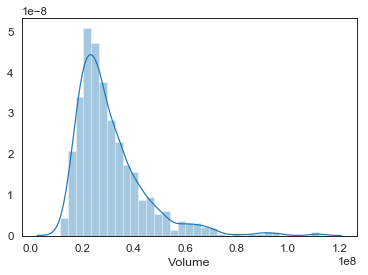

In [249]:
sns.distplot(df.Volume);
print( 'Kurtosis of the distribution: {}'.format(stats.kurtosis(df.Volume)))
print( 'Skewness of the distribution: {}'.format(stats.skew(df.Volume)))


Normal Distribution has a kurtosis of close to 0. If the kurtosis is greater than zero, then distribution has heavier tails. If the kurtosis is less than zero, then the distribution is light tails. And our Kurtosis is greater than zero.

If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed. If the skewness is less than -1 or greater than 1, the data are highly skewed. And our skewness is greater than 1.

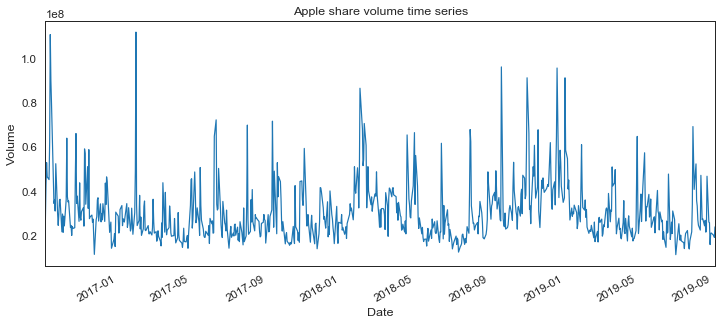

In [250]:
# plot volume with repect to date
df1 = df.loc[:,["Date","Volume"]]
df1.set_index("Date",inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel("Volume")
plt.legend().set_visible(False)
plt.title("Apple share volume time series")
plt.show()

# Box Plot of Yearly vs. Quarterly Volume

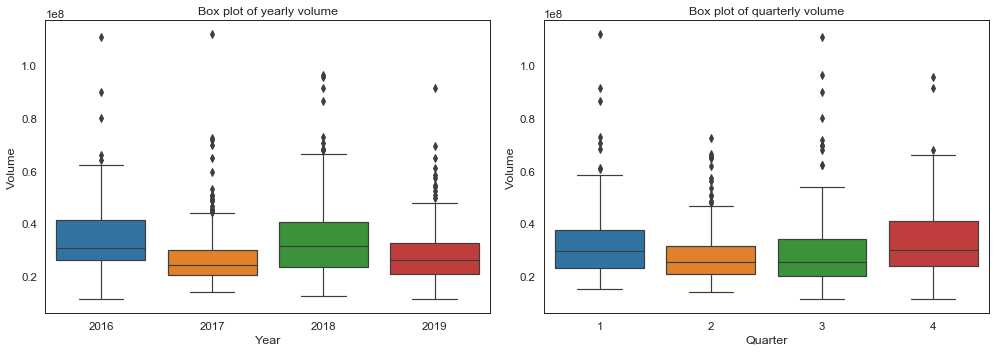

In [251]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="Year",y="Volume",data=df)
plt.xlabel("Year")
plt.ylabel("Volume")
plt.title("Box plot of yearly volume")
plt.tight_layout()

plt.subplot(1,2,2)
sns.boxplot(x="Quarter",y="Volume",data=df)
plt.xlabel("Quarter")
plt.ylabel("Volume")
plt.title("Box plot of quarterly volume")
plt.tight_layout()


In [42]:
#We see that median volume sold was highest in 2018 and that is in first and last quarter.

# Average Volume Resampled Over Day, Week, Month, Quarter and Year

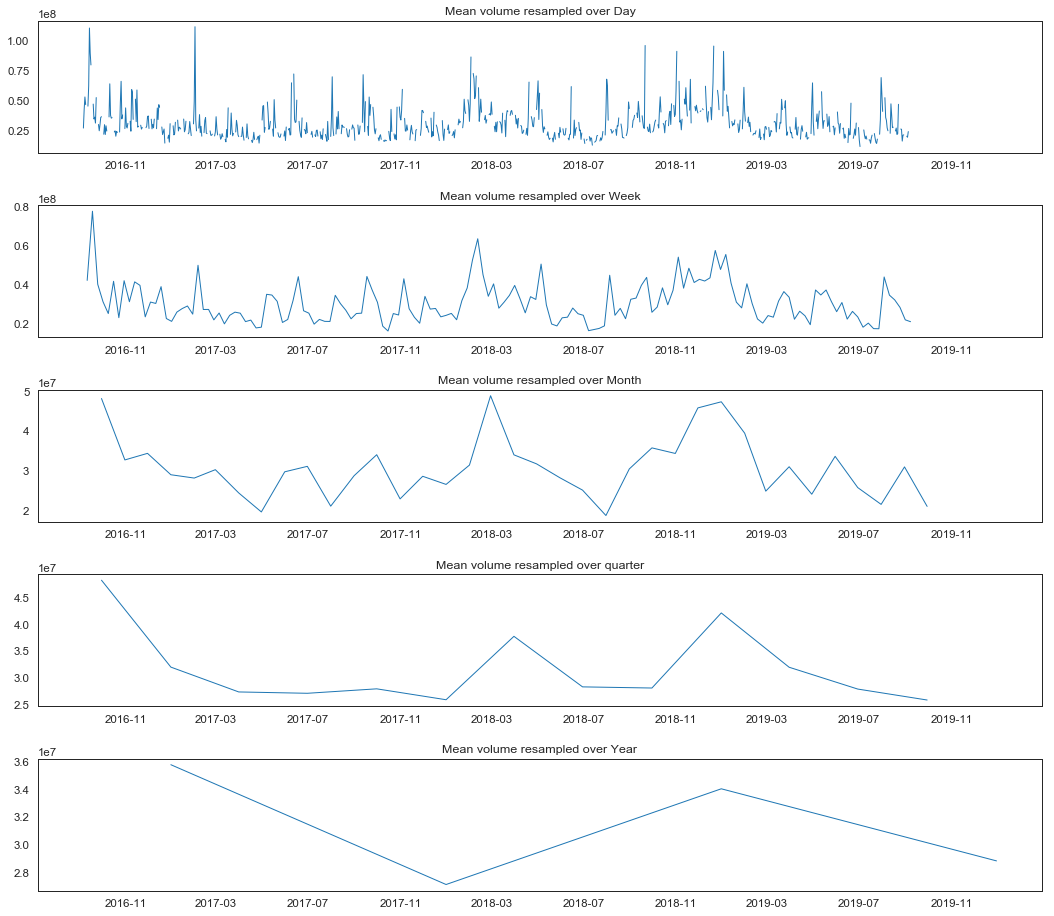

In [252]:
fig =plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 =  fig.add_subplot(5,1,1)
ax1.plot(df1["Volume"].resample('D').mean(),linewidth=1)
ax1.set_title("Mean volume resampled over Day")
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1["Volume"].resample('W').mean(),linewidth=1)
ax2.set_title("Mean volume resampled over Week")
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1["Volume"].resample('M').mean(),linewidth=1)
ax3.set_title("Mean volume resampled over Month")
ax3.tick_params(axis='both', which='major')

ax4 = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1["Volume"].resample('Q').mean(),linewidth=1)
ax4.set_title("Mean volume resampled over quarter")
ax4.tick_params(axis='both', which='major')

ax5 = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1["Volume"].resample('A').mean(),linewidth=1)
ax5.set_title("Mean volume resampled over Year")
ax5.tick_params(axis='both', which='major')

In [253]:
# Well our time series doesn't show any upward or downward trend, We do see that volume increase near second quarter 2018 and 
# decrease near second quarter 2019
#now we check for stationarity
# Null hypothesis is that series is not stationary
result =adfuller(df["Volume"],autolag='AIC')
dfout = pd.Series(result[:4],index=["Test Statistic","p Value","Lags used","Samples used"])
for key,value in dfout.items():
    print("%s is %s"%(key,value))

Test Statistic is -8.139176958156483
p Value is 1.0393055471911279e-12
Lags used is 3.0
Samples used is 751.0


# From the above results, we will reject the null hypothesis H0, the data does not have a unit root and is stationary.

# LSTM!


The following data pre-processing and feature engineering need to be done before construct the LSTM model.

1. Create the dataset, ensure all data is float.

2. Normalize the features.

3. Split into training and test sets.

4. Convert an array of values into a dataset matrix.

5. Reshape into X=t and Y=t+1.

6. Reshape input to be 3D (num_samples, num_timesteps, num_features).

In [255]:
dataset =  df["Volume"].values
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
dataset.shape

(755, 1)

In [256]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
trainSize =int(len(dataset)*.80)
testSize = len(dataset) - trainSize
train,test = dataset[0:trainSize,:],dataset[trainSize:len(dataset),:]
print(train.shape,test.shape)

(604, 1) (151, 1)


In [257]:
def seriesToSupervised(data,lookback=1):
    X,y = list(),list()
    for i in range(len(data)-lookback-1):
        xTemp = data[i:(i+lookback),0]
        yTemp = data[i+lookback,0]
        X.append(xTemp)
        y.append(yTemp)
    return np.array(X),np.array(y)
lookback= 30
x_train,y_train = seriesToSupervised(train,lookback)
x_test,y_test= seriesToSupervised(test,lookback)
print( x_train.shape,x_test.shape)

(573, 30) (120, 30)


In [258]:
#sample data - We are using 30 days sequence to produce 31st day's volume
for i in range(2):
    print(x_train[i,:],y_train[i])

[0.1542232  0.30810353 0.41382188 0.34977093 0.3372072  0.5049959
 0.9891049  0.7813482  0.6810063  0.3544021  0.23008955 0.24488637
 0.19589955 0.40864617 0.18392813 0.13163392 0.18165928 0.24373156
 0.24862209 0.10275783 0.18261033 0.10028622 0.17309463 0.12915935
 0.24719995 0.52352846 0.26062432 0.23682857 0.2413981  0.12186976] 0.13109827
[0.30810353 0.41382188 0.34977093 0.3372072  0.5049959  0.9891049
 0.7813482  0.6810063  0.3544021  0.23008955 0.24488637 0.19589955
 0.40864617 0.18392813 0.13163392 0.18165928 0.24373156 0.24862209
 0.10275783 0.18261033 0.10028622 0.17309463 0.12915935 0.24719995
 0.52352846 0.26062432 0.23682857 0.2413981  0.12186976 0.13109827] 0.08618905


In [259]:
# reshape input to be [samples, time steps, features]
x_train = x_train.reshape(573,1,30)
x_test = x_test.reshape(120,1,30)


In [260]:
#Model declaration
#Define the LSTM with 30 neurons in the first hidden layer , 10 in seond layer and 1 neuron in the output layer for predicting Volume.
#The input shape will be 1 time step with 30 features.
model = Sequential()

model.add(LSTM(30, input_shape=(x_train.shape[1], x_train.shape[2]),return_sequences=True))

model.add(LSTM(10))

#model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

trModel = model.fit(x_train, y_train, epochs=200, batch_size=30, validation_data=(x_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

Train on 573 samples, validate on 120 samples
Epoch 1/200
573/573 [==============================] - 3s 6ms/step - loss: 0.0343 - val_loss: 0.0154
Epoch 2/200
573/573 [==============================] - 0s 363us/step - loss: 0.0170 - val_loss: 0.0125
Epoch 3/200
573/573 [==============================] - 0s 283us/step - loss: 0.0160 - val_loss: 0.0123
Epoch 4/200
573/573 [==============================] - 0s 241us/step - loss: 0.0158 - val_loss: 0.0118
Epoch 5/200
573/573 [==============================] - 0s 257us/step - loss: 0.0155 - val_loss: 0.0117
Epoch 6/200
573/573 [==============================] - 0s 297us/step - loss: 0.0153 - val_loss: 0.0116
Epoch 7/200
573/573 [==============================] - 0s 253us/step - loss: 0.0151 - val_loss: 0.0114
Epoch 8/200
573/573 [==============================] - 0s 248us/step - loss: 0.0148 - val_loss: 0.0112
Epoch 9/200
573/573 [==============================] - 0s 251us/step - loss: 0.0146 - val_loss: 0.0110
Epoch 10/200
573/573 [=======

Epoch 79/200
573/573 [==============================] - 0s 318us/step - loss: 0.0116 - val_loss: 0.0088
Epoch 80/200
573/573 [==============================] - 0s 281us/step - loss: 0.0116 - val_loss: 0.0088
Epoch 81/200
573/573 [==============================] - 0s 312us/step - loss: 0.0116 - val_loss: 0.0088
Epoch 82/200
573/573 [==============================] - 0s 265us/step - loss: 0.0115 - val_loss: 0.0087
Epoch 83/200
573/573 [==============================] - 0s 281us/step - loss: 0.0115 - val_loss: 0.0087
Epoch 84/200
573/573 [==============================] - 0s 206us/step - loss: 0.0115 - val_loss: 0.0087
Epoch 85/200
573/573 [==============================] - 0s 243us/step - loss: 0.0115 - val_loss: 0.0087
Epoch 86/200
573/573 [==============================] - 0s 262us/step - loss: 0.0115 - val_loss: 0.0087
Epoch 87/200
573/573 [==============================] - 0s 274us/step - loss: 0.0115 - val_loss: 0.0087
Epoch 88/200
573/573 [==============================] - 0s 337us

In [261]:
# Predict the values for train and test
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)
# check difference by looking at output
print(train_predict[:2,0])
print(y_train[:2])


[0.14295456 0.08946212]
[0.13109827 0.08618905]


In [262]:
# We see that for training data, network over predicted a bit .011 units for first and .003 for second
# Since above predictions were in normalized space, we need to take inverse transformation. 
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

In [263]:
# as we already explained earlier that since units are so high, error would be higher as well, 
# but if we look closely it is not that high
print('Train Mean Absolute Error:', mean_absolute_error(y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 7106464.088920158
Train Root Mean Squared Error: 10193470.648453357
Test Mean Absolute Error: 6834800.411219312
Test Root Mean Squared Error: 9277749.008418815


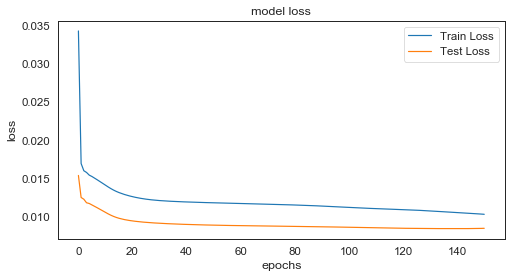

In [264]:
plt.figure(figsize=(8,4))
plt.plot(trModel.history['loss'], label='Train Loss')
plt.plot(trModel.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

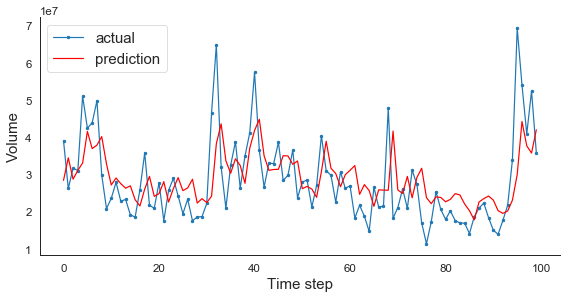

In [265]:
# See model fit on test data
aa=[x for x in range(100)]
plt.figure(figsize=(8,4))
plt.plot(aa, y_test[0][:100], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:100], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Volume', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

# From the above graph it is evident that network is able to identify the trend

In [267]:
#predicting over a new data input
new_input = np.array([32264500., 58840500., 27632000., 28428900., 29264600., 25965500.,
       27426400., 11475900., 27194000., 28528800., 36162300., 37086900.,
       26528000., 34324500., 26195500., 29998700., 27068300., 34402600.,
       26374400., 43733800., 34031800., 46524500., 44351100., 27779400.,
       21425000., 23783200., 26085900., 14249500., 18296900., 20905900.])


In [268]:
new_input= new_input.reshape(-1,1)
new_input = scaler.transform(new_input)
new_input = new_input.reshape(1,1,30)
res = model.predict(new_input)
res = scaler.inverse_transform([res[0]])
res

array([[25987315.00631765]])